Initial shape: (10000, 14)
   age      gender employment_status work_environment mental_health_history  \
0   56        Male          Employed          On-site                   Yes   
1   46      Female           Student          On-site                    No   
2   32      Female          Employed          On-site                   Yes   
3   60  Non-binary     Self-employed          On-site                    No   
4   25      Female     Self-employed          On-site                   Yes   

  seeks_treatment  stress_level  sleep_hours  physical_activity_days  \
0             Yes             6          6.2                       3   
1             Yes            10          9.0                       4   
2              No             7          7.7                       2   
3              No             4          4.5                       4   
4             Yes             3          5.4                       0   

   depression_score  anxiety_score  social_support_score  product

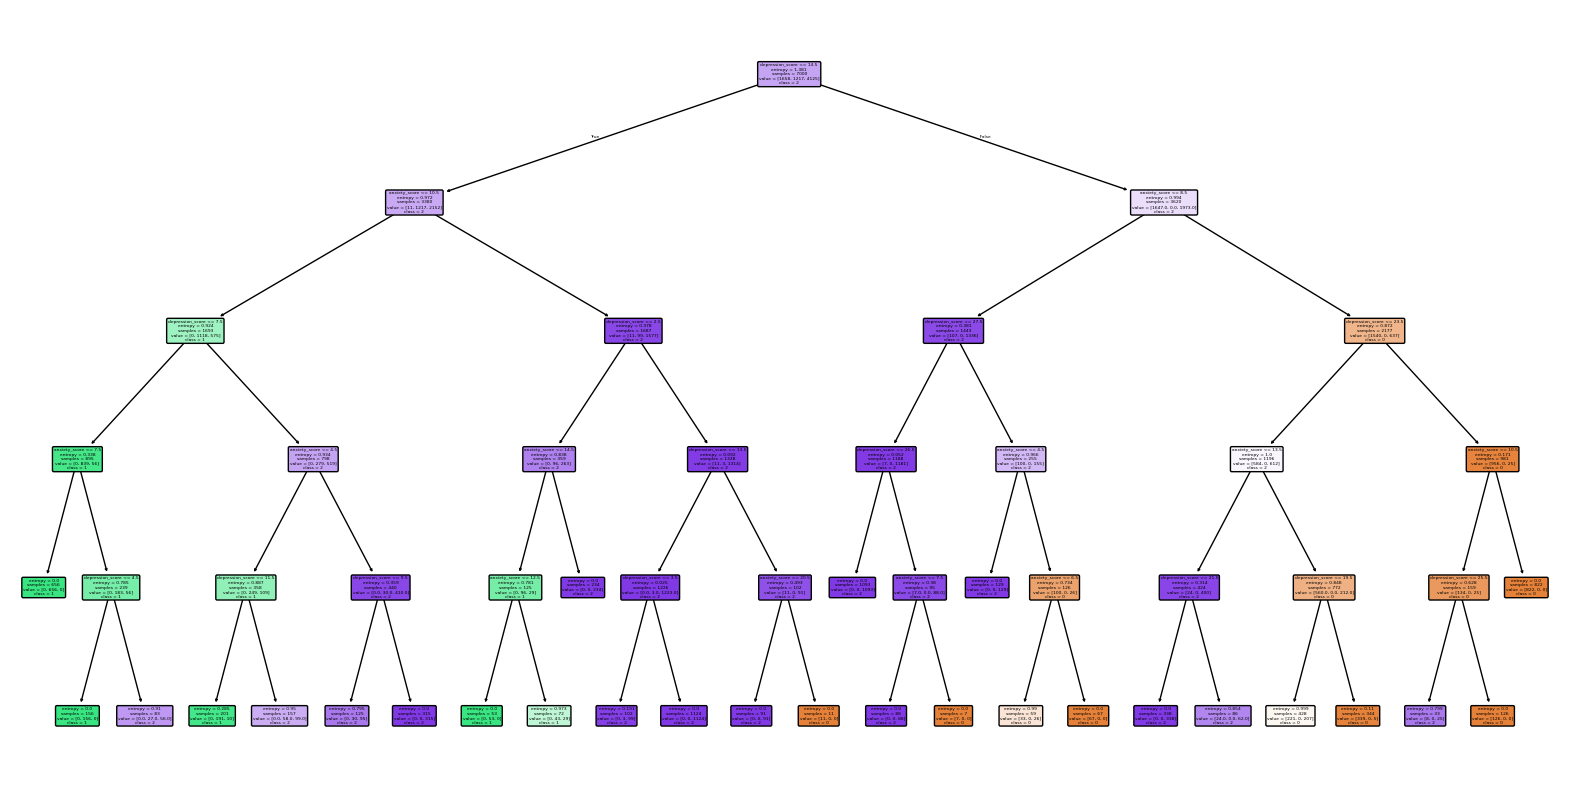


Pruning Results:
    max_depth  min_samples_split  train_acc  test_acc
0         NaN                  2   1.000000  1.000000
1         NaN                 10   1.000000  1.000000
2         NaN                 20   0.996000  0.993667
3         3.0                  2   0.834143  0.835667
4         3.0                 10   0.834143  0.835667
5         3.0                 20   0.834143  0.835667
6         5.0                  2   0.939000  0.934667
7         5.0                 10   0.939000  0.934667
8         5.0                 20   0.939000  0.934667
9         7.0                  2   0.979857  0.977000
10        7.0                 10   0.979857  0.977000
11        7.0                 20   0.979143  0.975667
12       10.0                  2   1.000000  1.000000
13       10.0                 10   1.000000  1.000000
14       10.0                 20   0.996000  0.993667


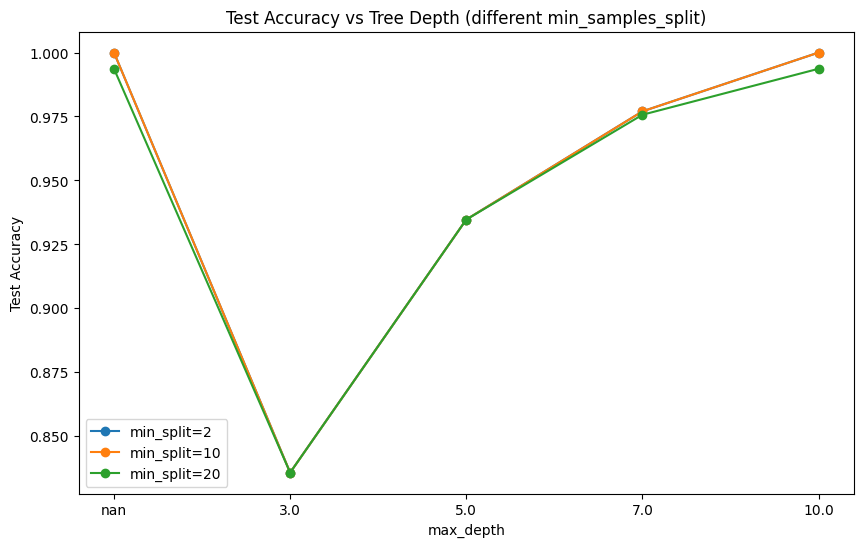

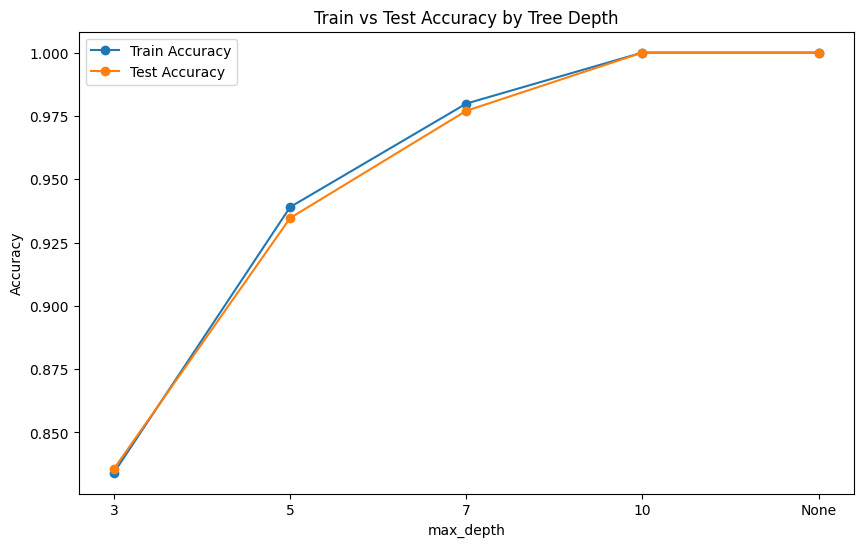

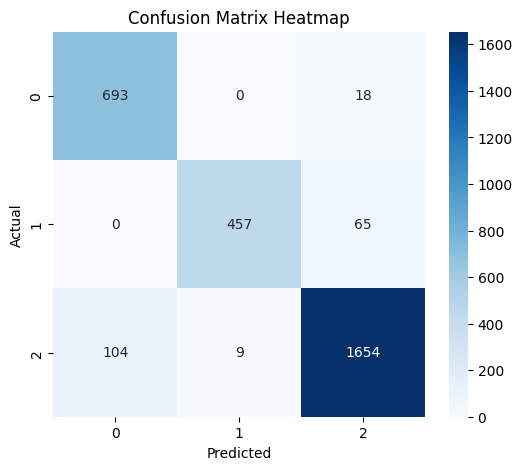

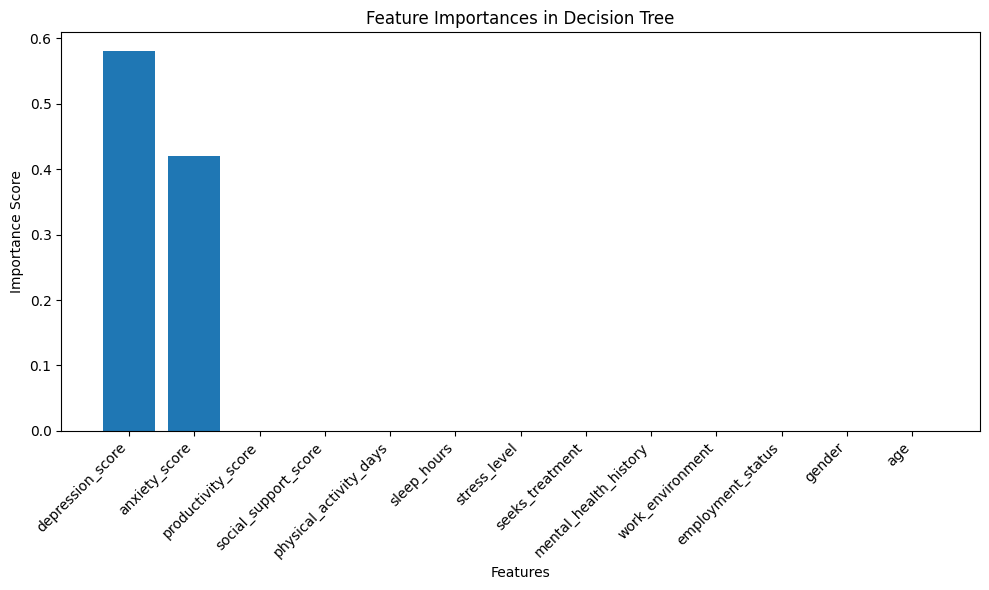


Feature Importances (ranked):
depression_score: 0.580
anxiety_score: 0.420
productivity_score: 0.000
social_support_score: 0.000
physical_activity_days: 0.000
sleep_hours: 0.000
stress_level: 0.000
seeks_treatment: 0.000
mental_health_history: 0.000
work_environment: 0.000
employment_status: 0.000
gender: 0.000
age: 0.000


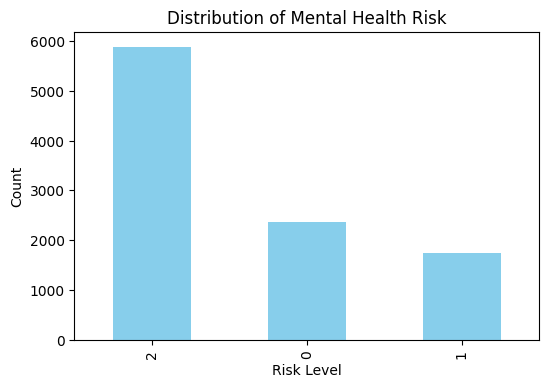

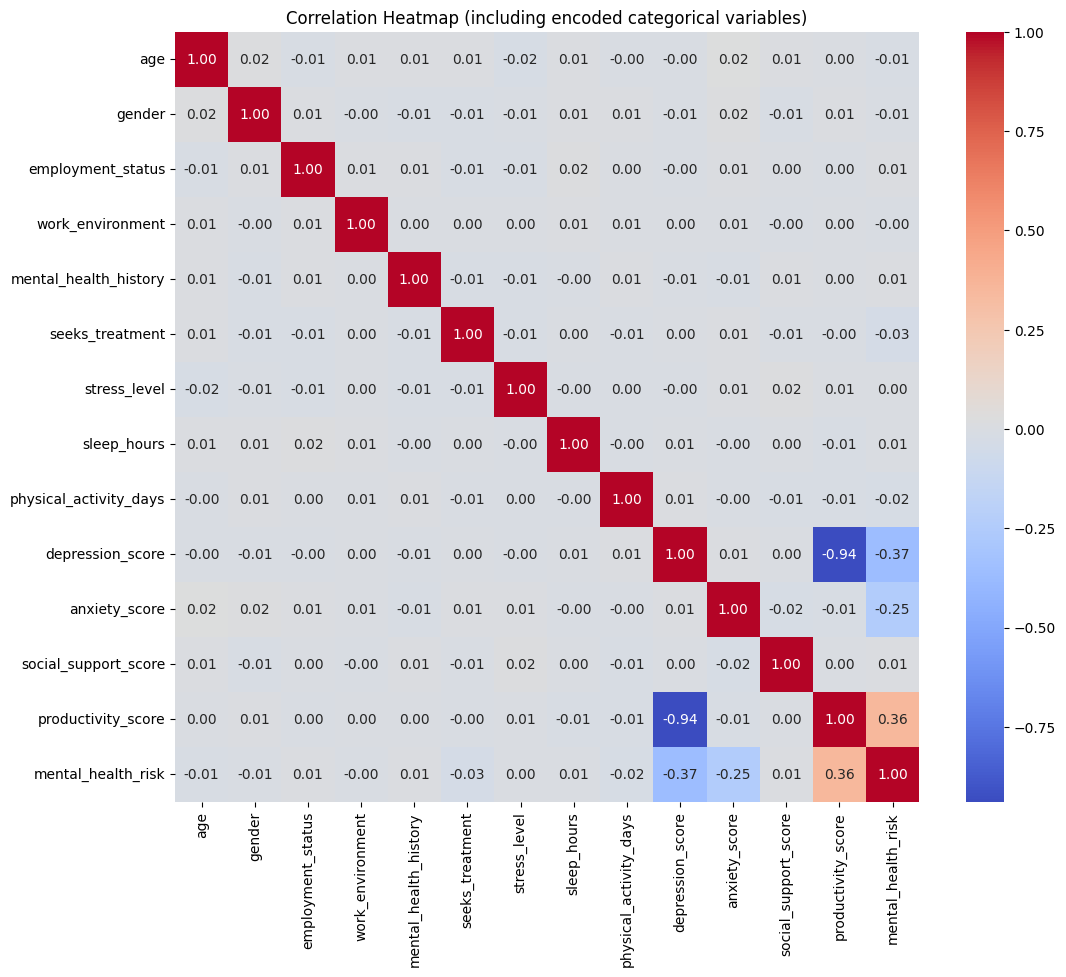

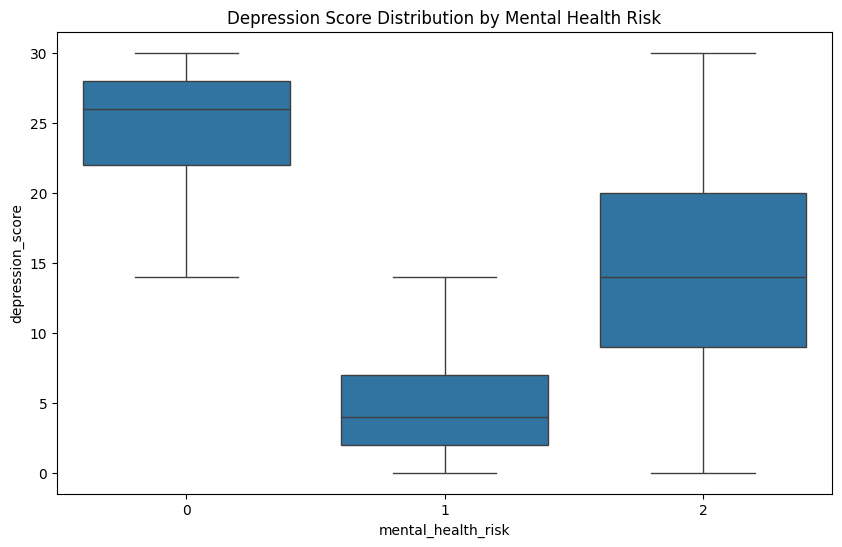

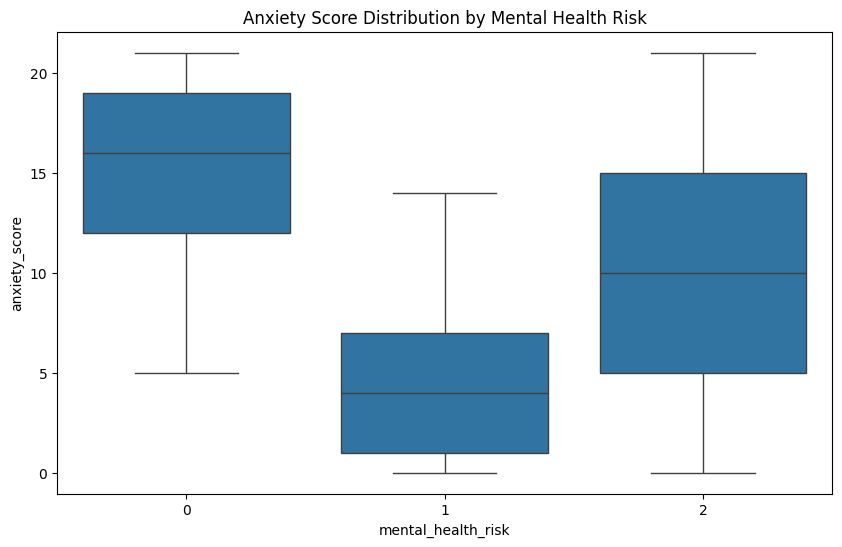

In [2]:
# Decision Tree Analysis on Mental Health Dataset
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
df = pd.read_csv("mental_health_dataset.csv")  # Dataset contains mental health metrics and risk levels
print("Initial shape:", df.shape)
print(df.head())

# Handle missing values by dropping rows with any NaNs (simplest approach for this analysis)
df = df.dropna()
print("After dropping NA:", df.shape)

# Encode categorical features into numerical values for the Decision Tree model
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders in case we need to inverse transform later

# Display descriptive statistics for both numeric and encoded categorical features
print("\n--- Descriptive Statistics ---")
print(df.describe(include="all"))

# Define features (X) and target (y)
target_column = "mental_health_risk"   # Classification target for mental health risk levels
X = df.drop(columns=[target_column])
y = df[target_column]

# Split data into training and testing sets with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train a baseline Decision Tree classifier with limited depth to avoid overfitting
clf = DecisionTreeClassifier(
    criterion="entropy",  # Use information gain to split nodes
    max_depth=5,          # Maximum tree depth
    random_state=42
)
clf.fit(X_train, y_train)

# Evaluate the baseline tree performance
y_pred = clf.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize the structure of the baseline Decision Tree
plt.figure(figsize=(20,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=np.unique(y).astype(str),
    filled=True,
    rounded=True
)
plt.show()

# Part 2: Pruning Experiments
# Function to train a Decision Tree with specified hyperparameters and return train/test accuracy
def evaluate_tree(max_depth=None, min_samples_split=2):
    """
    Trains a Decision Tree with given max_depth and min_samples_split,
    and returns training and testing accuracy.
    """
    clf = DecisionTreeClassifier(
        criterion="entropy",
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    return (
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test)
    )

# Explore impact of tree depth and min_samples_split on model performance
results = []
for depth in [None, 3, 5, 7, 10]:          # Different tree depths for pruning
    for min_split in [2, 10, 20]:          # Different minimum samples required to split a node
        train_acc, test_acc = evaluate_tree(max_depth=depth, min_samples_split=min_split)
        results.append({
            "max_depth": depth,
            "min_samples_split": min_split,
            "train_acc": train_acc,
            "test_acc": test_acc
        })

results_df = pd.DataFrame(results)
print("\nPruning Results:")
print(results_df)

# Plot test accuracy vs max_depth for different min_samples_split values
plt.figure(figsize=(10,6))
for min_split in results_df["min_samples_split"].unique():
    subset = results_df[results_df["min_samples_split"] == min_split]
    plt.plot(subset["max_depth"].astype(str), subset["test_acc"], marker="o", label=f"min_split={min_split}")

plt.xlabel("max_depth")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Tree Depth (different min_samples_split)")
plt.legend()
plt.show()

# Compare training vs testing accuracy across tree depths to identify overfitting
plt.figure(figsize=(10,6))
depths = [3, 5, 7, 10, None]
train_accs, test_accs = [], []
for d in depths:
    tr, te = evaluate_tree(max_depth=d)
    train_accs.append(tr)
    test_accs.append(te)

labels = [str(d) for d in depths]
plt.plot(labels, train_accs, marker="o", label="Train Accuracy")
plt.plot(labels, test_accs, marker="o", label="Test Accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy by Tree Depth")
plt.legend()
plt.show()

# Part 3: Confusion Matrix Visualization
# Heatmap to visualize correct and incorrect predictions for each class
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Part 4: Feature Importance
# Determine which features contribute most to the model's predictions
importances = clf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]  # Sort features by importance descending

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha="right")
plt.title("Feature Importances in Decision Tree")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

print("\nFeature Importances (ranked):")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.3f}")

# Part 5: Extra Visualizations

# Bar plot to show distribution of the target variable
plt.figure(figsize=(6,4))
df[target_column].value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribution of Mental Health Risk")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()

# Correlation heatmap for all numeric features (including encoded categorical variables)
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap (including encoded categorical variables)")
plt.show()

# Boxplots to compare numeric features across different risk levels
plt.figure(figsize=(10,6))
sns.boxplot(x=target_column, y="depression_score", data=df)
plt.title("Depression Score Distribution by Mental Health Risk")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=target_column, y="anxiety_score", data=df)
plt.title("Anxiety Score Distribution by Mental Health Risk")
plt.show()
